In [1]:
import pandas as pd
from sklearn.compose import ColumnTransformer 
from sklearn.preprocessing import LabelEncoder
from hyperopt import hp
from sklearn.pipeline import Pipeline
from transformers.categorical_transformer import CategoricalTransformer
from transformers.numerical_transformer import NumericalTransformer
from transformers.feature_selection_transformer import FeatureTransformer
from estimators.lr_estimator import LogisticRegressionEstimator
from estimators.rfc_estimator import RandomForestEstimator
from functions import *


In [2]:
df = pd.read_csv("./WA_Fn-UseC_-HR-Employee-Attrition.csv")
_target_column = "Attrition"
df = df.sample(frac=1, random_state=1).reset_index(drop=True)
df.drop(columns="EmployeeNumber",inplace=True, axis=1)

In [3]:
df

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EnvironmentSatisfaction,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,37,Yes,Travel_Rarely,370,Research & Development,10,4,Medical,1,4,...,2,80,0,10,4,1,10,3,0,8
1,18,Yes,Travel_Frequently,544,Sales,3,2,Medical,1,2,...,3,80,0,0,2,4,0,0,0,0
2,30,Yes,Travel_Rarely,138,Research & Development,22,3,Life Sciences,1,1,...,2,80,0,7,2,3,5,2,0,1
3,34,No,Travel_Rarely,1333,Sales,10,4,Life Sciences,1,3,...,4,80,1,1,2,3,1,1,0,0
4,56,No,Travel_Rarely,1369,Research & Development,23,3,Life Sciences,1,4,...,1,80,1,33,0,3,19,16,15,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,33,No,Travel_Frequently,827,Research & Development,1,4,Other,1,3,...,1,80,1,6,2,3,6,5,1,2
1466,29,No,Travel_Rarely,694,Research & Development,1,3,Life Sciences,1,4,...,2,80,2,9,2,2,7,7,1,7
1467,40,No,Travel_Rarely,898,Human Resources,6,2,Medical,1,3,...,4,80,0,21,2,3,21,7,7,7
1468,43,No,Travel_Rarely,1034,Sales,16,3,Marketing,1,4,...,3,80,1,22,3,3,17,13,1,9


In [11]:
df = distribute_data_equally(df,_target_column)

In [12]:
# Encoding target variables
label_encoder = LabelEncoder()
df[_target_column] = label_encoder.fit_transform(df[_target_column])

In [13]:
train_data, train_labels, test_data, test_labels = split_dataset(df, _target_column, 0.15)
print(f"Number of rows in train data: {len(train_data)}")
print(f"Number of rows in test data: {len(test_data)}")

Number of rows in train data: 402
Number of rows in test data: 72


In [14]:
cat_transformer = CategoricalTransformer(drop_single_column=True)
preprocessing_pipeline = Pipeline(steps=[
        ("categorical_transformer",cat_transformer),
        ("numerical_transformer",NumericalTransformer(target_column=_target_column))
        ])
feature_selection_pipeline = Pipeline(steps=[
       ("feature_importance_transformer", FeatureTransformer(threshold=10))
])

CategoricalTransformer constructor is called
>>>>> NumericalTransformer constructor called
>>>>>> feature transformer constructor called


d:\Github Profile\churn-prediction-pipeline\transformers\categorical_transformer.py:14: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



In [29]:
search_space = {
    "solver": hp.choice("solver",['lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga']),
    "C": hp.quniform("C",1,30,2),
    "max_iter": hp.quniform("max_iter",100,1000,100)
}
parameters={
       "iterations":120,
       "kfolds":5
}
lr_estimator = LogisticRegressionEstimator(target_column=_target_column, tune_hyperparameter=True, search_space= search_space, parameters = parameters)

In [30]:
search_space = {
    "n_estimators":hp.uniformint("n_estimators",100,1000),
    "bootstrap":hp.choice("bootstrap",[True, False]),
    "max_depth": hp.uniformint("max_depth",10,100),
    "max_features":hp.choice("max_features",["sqrt", "log2", None]),
    
}
parameters={
       "iterations":120,
       "kfolds":5
}
rfc_estimator = RandomForestEstimator(target_column=_target_column, tune_hyperparameter=True, search_space= search_space, parameters = parameters)

In [31]:
lr_pipeline = Pipeline(steps=[   
                                    ("preprocessing_pipeline",preprocessing_pipeline),
                                    ("feature_selection",feature_selection_pipeline),    
                                    ("estimator", lr_estimator)
                                ]
                          )
rfc_pipeline = Pipeline(steps=[   
                                    ("preprocessing_pipeline",preprocessing_pipeline),
                                    ("feature_selection",feature_selection_pipeline),    
                                    ("model", rfc_estimator)
                                ]
                          )


In [32]:
# logistic regression pipeline fit
lr_pipeline.fit(train_data,train_labels)

>>>>>> Categorically fit_transformer called
>>>>>> Categorically fit called
>>>>>> Categorically transformer called
>>>>> Numerical Transformer transform method called
>>>>>> feature transformer fit method called
>>>>>> feature transformer transform called
>>>>>>>>>> Estimator Fit method is called
Tuning Hyper-parameter for Logistic Regression
100%|██████████| 120/120 [00:05<00:00, 20.75trial/s, best loss: 0.27089506172839506]
Tuning completed
Best parameters for Logistic Regression are: {'C': 26.0, 'max_iter': 200.0, 'solver': 'newton-cg'}


Pipeline(steps=[('preprocessing_pipeline',
                 Pipeline(steps=[('categorical_transformer',
                                  CategoricalTransformer()),
                                 ('numerical_transformer',
                                  NumericalTransformer())])),
                ('feature_selection',
                 Pipeline(steps=[('feature_importance_transformer',
                                  FeatureTransformer(threshold=10))])),
                ('estimator',
                 <estimators.lr_estimator.LogisticRegressionEstimator object at 0x0000022980382350>)])

>>>>>> Categorically transformer called
>>>>> Numerical Transformer transform method called
>>>>>> feature transformer transform called
Index(['Age', 'EnvironmentSatisfaction', 'JobInvolvement', 'JobLevel',
       'JobRole', 'MaritalStatus', 'MonthlyIncome', 'OverTime',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsWithCurrManager'],
      dtype='object')
              precision    recall  f1-score   support

           0       0.75      0.75      0.75        36
           1       0.75      0.75      0.75        36

    accuracy                           0.75        72
   macro avg       0.75      0.75      0.75        72
weighted avg       0.75      0.75      0.75        72

Total accuracy: 0.75


d:\Github Profile\churn-prediction-pipeline\transformers\categorical_transformer.py:85: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



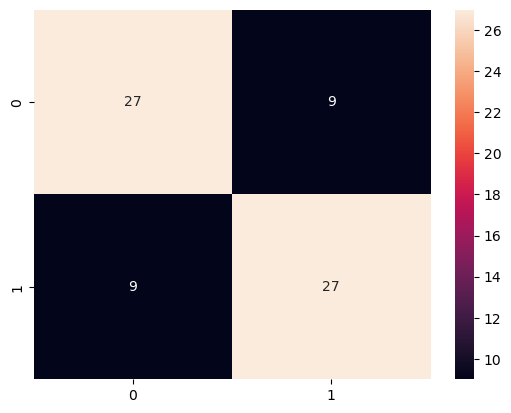

In [33]:
# Logistic Regression Prediction
y_pred = lr_pipeline.predict(test_data)
show_confusion_matrix(test_labels, y_pred)

In [ ]:
# Random forest pipeline
rfc_pipeline.fit(train_data,train_labels)

>>>>>> Categorically fit_transformer called
>>>>>> Categorically fit called
>>>>>> Categorically transformer called
>>>>> Numerical Transformer transform method called
>>>>>> feature transformer fit method called
>>>>>> feature transformer transform called
>>>>>>>>>> Estimator Fit method is called
Tuning Hyper-parameter for Logistic Regression
100%|██████████| 120/120 [00:06<00:00, 18.59trial/s, best loss: 0.2958333333333334]
Tuning completed
Best parameters for Logistic Regression are: {'C': 2.0, 'max_iter': 100.0, 'solver': 'sag'}
>>>>>> Categorically fit_transformer called
>>>>>> Categorically fit called
>>>>>> Categorically transformer called
>>>>> Numerical Transformer transform method called
>>>>>> feature transformer fit method called
>>>>>> feature transformer transform called
>> Training Random forest
Tuning Hyper-parameter for Random Forest
100%|██████████| 120/120 [09:38<00:00,  4.82s/trial, best loss: 0.28330246913580237]
Tuning completed
Best parameters for Random Forest a

>>>>>> Categorically transformer called
>>>>> Numerical Transformer transform method called
>>>>>> feature transformer transform called
Index(['Age', 'DailyRate', 'DistanceFromHome', 'EducationField',
       'EnvironmentSatisfaction', 'JobInvolvement', 'JobLevel',
       'MaritalStatus', 'MonthlyIncome', 'OverTime', 'StockOptionLevel',
       'TotalWorkingYears', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsWithCurrManager'],
      dtype='object')
              precision    recall  f1-score   support

           0       0.62      0.70      0.66        33
           1       0.71      0.64      0.68        39

    accuracy                           0.67        72
   macro avg       0.67      0.67      0.67        72
weighted avg       0.67      0.67      0.67        72

Total accuracy: 0.6666666666666666


d:\churn modelling\pipeline - 2.0\categorical_transformer.py:85: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



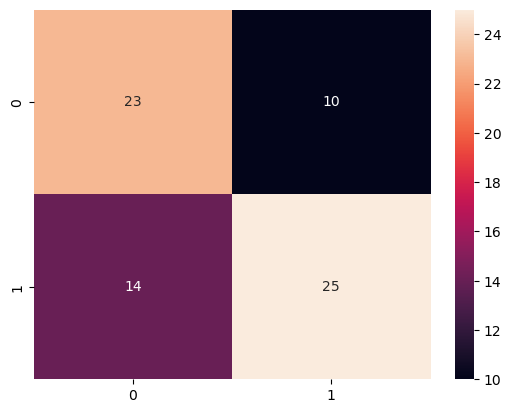

In [ ]:
# Random Forest Prediction
y_pred = rfc_pipeline.predict(test_data)
show_confusion_matrix(test_labels, y_pred)